In [1]:
%pylab inline
import glob, os, sys, fnmatch
from astropy.io import fits
import astropy.table
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate 
import pandas as pd
import astropy.table

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rc('font', size=10, family='serif')

In [3]:
from lmfit import models, Parameters, Parameter, Model
from lmfit.models import LinearModel, ConstantModel

In [4]:
sys.path.insert(0,'/Users/parkerf/Research/SkyModel/BOSS_Sky/Model/python/')
import sky_model

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
cont_files = glob.glob('/Users/parkerf/Research/SkyModel/BOSS_Sky/FitSpectra/split_files/*_split_flux.fits')

## Get bright clear data

In [7]:
cloud_data = np.load('/Users/parkerf/Research/SkyModel/BOSS_Sky/BrightSky/clouds/phot_rec.npy')
df = pd.DataFrame(cloud_data)

In [8]:
def get_cloud_data(line):
    clouds = df[(df['STARTTAI']<= line['TAI-BEG']) & (df['ENDTAI']>line['TAI-BEG'])]['PHOTOMETRIC'].values
    if len(clouds) == 0:
        clouds = df[(df['STARTTAI']< line['TAI-END']) & (df['ENDTAI']>=line['TAI-END'])]['PHOTOMETRIC'].values
    if len(clouds) == 0:
        clouds = 0.5
    
    return clouds

In [9]:
CloudDict = {}
for filen in cont_files:
    hdu = fits.open(filen)
    observations = hdu[1].data
    CloudDict[observations[0]['PLATE']] = {}
    for obs in observations:
        clouds = get_cloud_data(obs)
        CloudDict[obs['PLATE']][obs['IMG']] = clouds

In [10]:
Clear_Obs = []
for plate, info in CloudDict.items():
    for img, clouds in info.items():
        if clouds == 1.:
            Clear_Obs.append((int(plate),int(img)))

In [11]:
clear_cont_files = []
for plate in Clear_Obs:
    clear_cont_files.append('/Users/parkerf/Research/SkyModel/BOSS_Sky/FitSpectra/split_files/'+str(plate[0])+'_split_flux.fits')

In [12]:
clear_cont_files = np.unique(clear_cont_files)

In [13]:
Mhdu = fits.open('/Users/parkerf/Research/SkyModel/BOSS_Sky/Analysis/MetaData/good_meta_rich.fits')
MetaData = astropy.table.Table(Mhdu[1].data)
def get_specnos(meta):
    plate = meta['PLATE']
    image = meta['IMG']
    this_meta = MetaData[(MetaData['PLATE'] == plate) & (MetaData['IMG'] == image) & ((MetaData['CAMERAS'] == 'b1')|(MetaData['CAMERAS'] == 'b2'))]
    specnos = this_meta['SPECNO']
    return np.array(specnos)

In [14]:
wave = np.linspace(360,630,(630-360)*10)
def make_mean_cont(hdulist, specnos, wave):
    spectra = []
    for specno in specnos:
        try:
            data = hdulist[str(specno)].data
            cont = interpolate.interp1d(data['WAVE'], data['CONT'], bounds_error=False, fill_value=0)
            spectra.append(cont(wave))
        except:
            pass
    return np.mean(spectra, axis = 0)

In [15]:
clear_observations = np.array(Clear_Obs)[:,1]

In [16]:
ClearMeta = []
for filen in clear_cont_files:
    hdu = fits.open(filen)
    observations = np.array(hdu[1].data)
    for obs in observations:
        if np.isin(int(obs['IMG']),clear_observations):
            ClearMeta.append(obs)

In [17]:
ClearMeta = astropy.table.Table(np.vstack(ClearMeta))

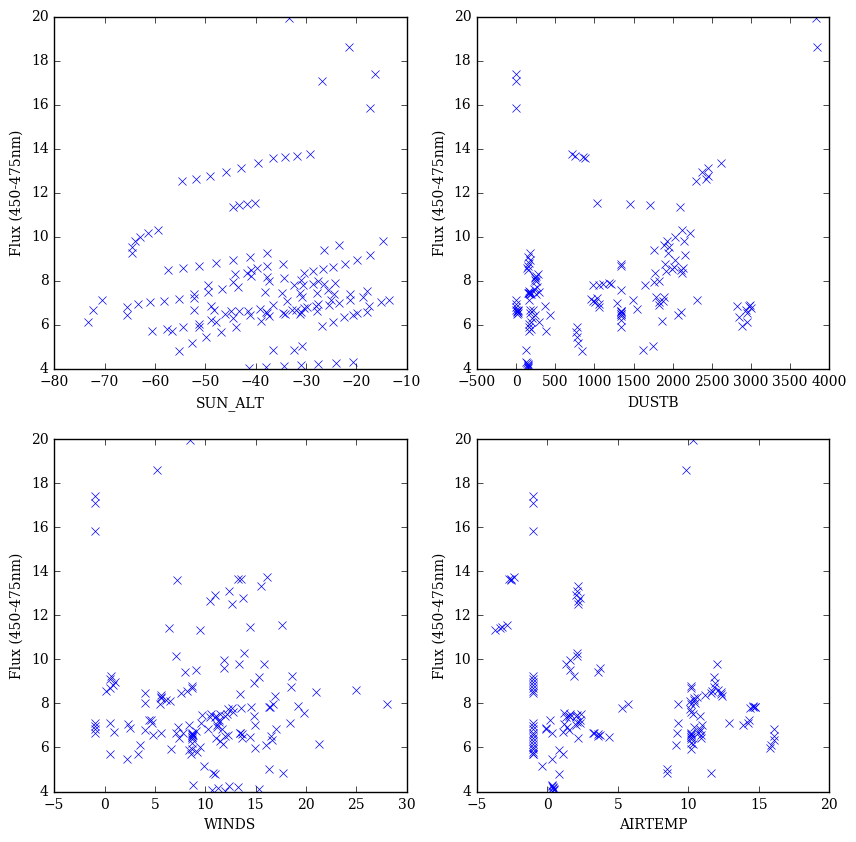

In [18]:
fig, axarr = plt.subplots(2,2, figsize = (10,10))
ax = axarr.ravel()
for i, param in enumerate(['SUN_ALT', 'DUSTB','WINDS','AIRTEMP']):
    ax[i].plot( ClearMeta[param],ClearMeta['SKY_VALUE'],'x')
    ax[i].set_xlabel(param)
    ax[i].set_ylabel('Flux (450-475nm)')

## Fit the spectra

In [19]:
from sky_model import SkyModel

In [20]:
# create new spectrum
Sky = SkyModel()
Sky.run_model()

In [21]:
def make_data_file(param_list, cont_files = True, save = True, name = 'with_logI'):
    Data = []
    Cont_spectra = []
    for filen in clear_cont_files:
        hdulist = fits.open(filen)
        ObsMeta = astropy.table.Table(hdulist[1].data)
        observations = ObsMeta
        for obs in observations:
            if np.isin(int(obs['IMG']), clear_observations):
                ThisObs = SkyModel(obs)
                ThisObs.run_model()
                if cont_files:
                    specnos = get_specnos(obs)
                    mc = make_mean_cont(hdulist, specnos, ThisObs.Model['wave_range'])
                    Cont_spectra.append(mc)

                this_dtype = [('EXT','f8'),('ZODI','f8'),('ISL','f8'),('MOON','f8')]
                for param in param_list:
                    this_dtype.append((param, 'f8'))
                
                spec=np.zeros(len(ThisObs.Model['wave_range']),dtype=this_dtype)
                spec['EXT'] = ThisObs.S.extinction_curve(ThisObs.ObsMeta['AIRMASS'])
                spec['ISL'] = ThisObs.I.isl_spectrum
                spec['MOON'] = ThisObs.M.moon_spectrum
                spec['ZODI'] = zodi = ThisObs.Z.zodi_flux
                for param in param_list:
                    spec[param] = np.ones(len(ThisObs.Model['wave_range']))*ThisObs.ObsMeta[param]
                Data.append(spec)
    if save:
        np.save('/Users/parkerf/Research/SkyModel/BOSS_Sky/FitSpectra/files/fit_data_model/%s' % name, Data)
    if cont_files:
        return Data, Cont_spectra
    else:
        return Data

In [22]:
Data, Cont_spectra = make_data_file(['MOON_SEP', 'SOLARFLUX', 'SUN_ALT','LOGI'])

In [23]:
def bright_sky_model(x, A, B, C, D, E, F, G, f_R0, f_R1, fscatt_i):

    fscatt_z = (f_R0*np.array(x['LOGI'])-f_R1)
    Zodi = np.array(x['ZODI'])*np.array(x['EXT'])**fscatt_z
    ISL = np.array(x['ISL'])*np.array(x['EXT'])**fscatt_i
    Moon = np.array(x['MOON'])*np.array(x['EXT'])*(A*np.cos(np.deg2rad(np.array(x['MOON_SEP']))))
    solar = B*np.array(x['SOLARFLUX'])
    sun = D*np.array(x['SUN_ALT'])
    sky = Moon + Zodi + ISL + solar + sun + C
    return sky

In [24]:
def NewModelWavelength(cont, data):
    def bright_sky_model(x, A, B, C, D, E, F, G, f_R0, f_R1, fscatt_i):

        fscatt_z = (f_R0*np.array(x['LOGI'])-f_R1)
        Zodi = np.array(x['ZODI'])*np.array(x['EXT'])**fscatt_z
        ISL = np.array(x['ISL'])
        Moon = np.array(x['MOON'])*np.array(x['EXT'])*(A*np.cos(np.deg2rad(np.array(x['MOON_SEP']))))
        solar = B*np.array(x['SOLARFLUX'])
        sun = D*np.array(x['SUN_ALT'])
        sky = Moon + Zodi + ISL + solar + sun + C
        return sky
    
    mod = Model(bright_sky_model)
    params = mod.make_params()
    params.add('A', value = 1)
    params.add('B', value = .01, min = 0)
    params.add('C', value = 0)
    params.add('D', value = 0.1, min = 0)
    params.add('E', value = 1)
    params.add('F', value = 1)
    params.add('G', value = 1)
    params.add('f_R0', value = 1.407, min = 0)
    params.add('f_R1', value = 2.692, min = 0)
    #params.add('f_M0', value = 0.5, min = 0)
    #params.add('f_M1', value = 0.7, min = 0)
    #params.add('fscatt_z', value = .2, min = .001)
    params.add('fscatt_i', value = .1, min = .001)
    #params.add('fscatt_m', value = .2, min = 0.001)

    result = mod.fit(cont, params, x = data)
    return result

In [25]:
T = astropy.table.Table(np.array(Data))
print(np.array(Data).dtype.names)

('EXT', 'ZODI', 'ISL', 'MOON', 'MOON_SEP', 'SOLARFLUX', 'SUN_ALT', 'LOGI')


In [26]:
Cont_spectra = np.array(Cont_spectra)
T = astropy.table.Table(np.array(Data))
Results = []
for i, cont in enumerate(Cont_spectra.T):
    data = []
    for param in np.array(Data).dtype.names:
        data.append(T[param][:,i])
    data = astropy.table.Table(data)
    try:
        results = NewModelWavelength(cont, data)
        Results.append(results)
    except:
        print('didnt work: ',i)

(365, 635)

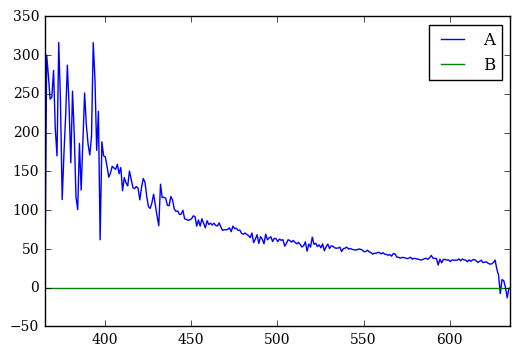

In [27]:
for name in ['A','B']:
    A = []
    for i, result in enumerate(Results):
        A.append(result.params[name].value)
    plt.plot(Sky.Model['wave_range'],A,label = name)
plt.legend()
plt.xlim(365,635)
#plt.ylim(-100,100)

In [28]:
def test_model(results,X):

    #fscatt_z = results.params['fscatt_z'].value
    #fscatt_i = results.params['fscatt_i'].value
    #fscatt_m = results.params['fscatt_m'].value
    
    A = results.params['A'].value
    B = results.params['B'].value
    C = results.params['C'].value
    D = results.params['D'].value
    E = results.params['E'].value
    F = results.params['F'].value
    G = results.params['G'].value
    f_R0 = results.params['f_R0'].value
    f_R1 = results.params['f_R1'].value
    fscatt_i = results.params['fscatt_i'].value
    #f_M0 = results.params['f_M0'].value
    #f_M1 = results.params['f_M1'].value

    sky = bright_sky_model(X,A, B, C, D, E, F, G, f_R0, f_R1, fscatt_i)

    return sky

In [29]:
data = []
for param in np.array(Data).dtype.names:
    data.append(This_Data[param][0])
nam = np.array(Data).dtype.names
print(list(names))
d = astropy.table.Table(np.array(data), names = nam) #(np.array(Data).dtype.names))
d

NameError: name 'This_Data' is not defined

In [30]:

RES = []
for i in range(len(Cont_spectra)):#,size = 10):#len(Cont_spectra)):
    This_spectrum = Cont_spectra[i]
    This_Data = T[i]
    Model_Spectrum = []
    for ii, result in enumerate(Results):
        data = []
        for param in np.array(Data).dtype.names:
            data.append(This_Data[param][ii])
        data = astropy.table.Table(np.array(data),names = np.array(Data).dtype.names)
        Model_Spectrum.append(test_model(result, data))
    
    res = This_spectrum - Model_Spectrum
    RES.append(np.mean(res))

2.61042840945


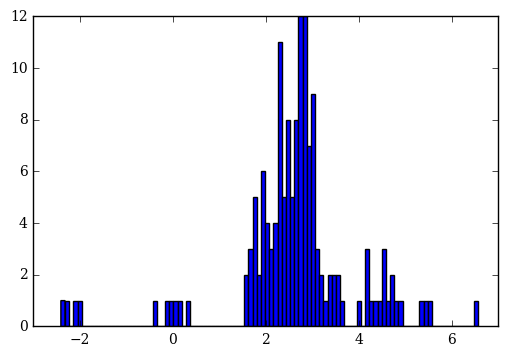

In [121]:
#without fscatt_z
r = plt.hist(RES, 100)
print(np.mean(RES))

-5.54688087174e-08


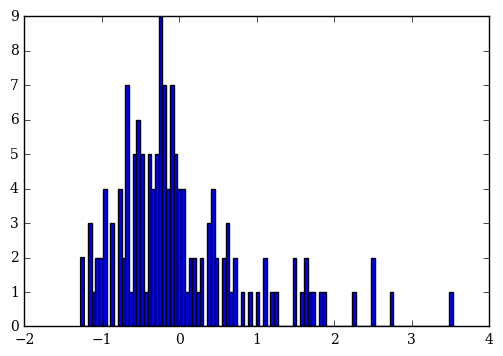

In [31]:
r = plt.hist(RES, 100)
print(np.mean(RES))

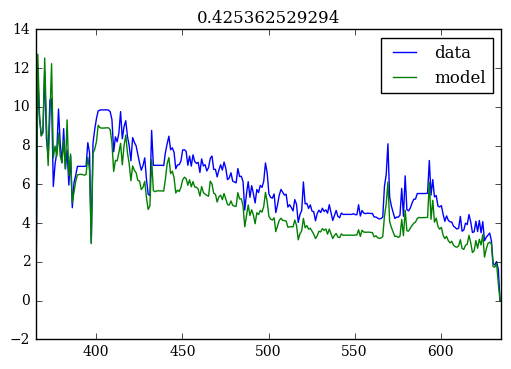

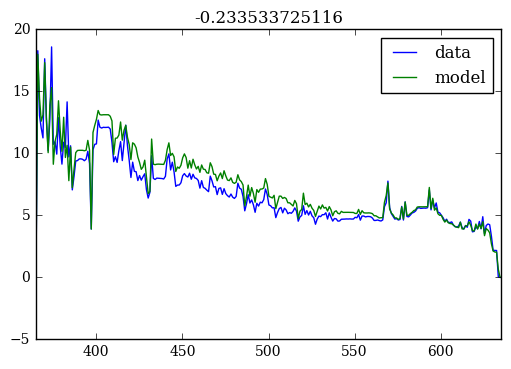

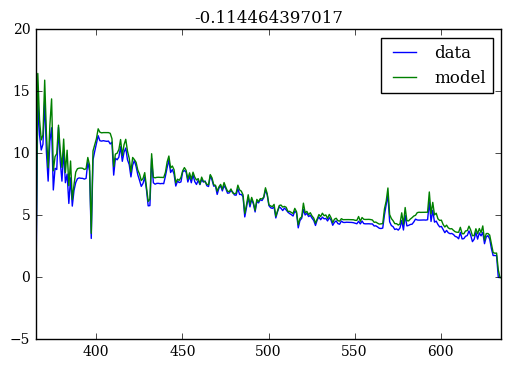

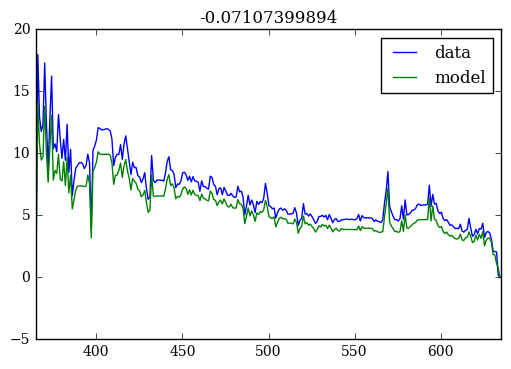

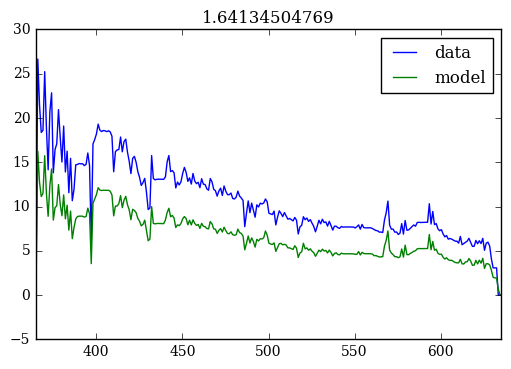

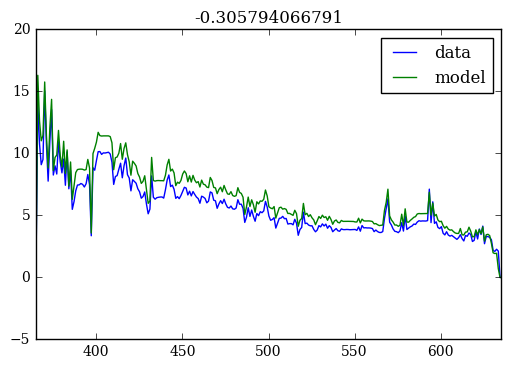

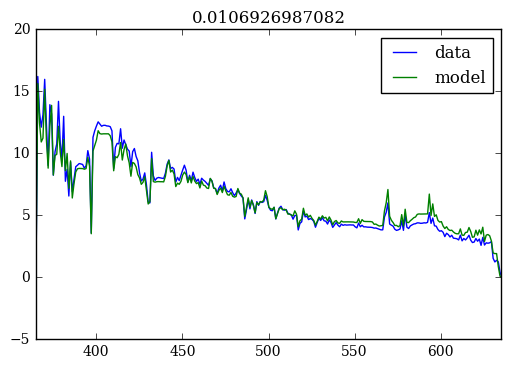

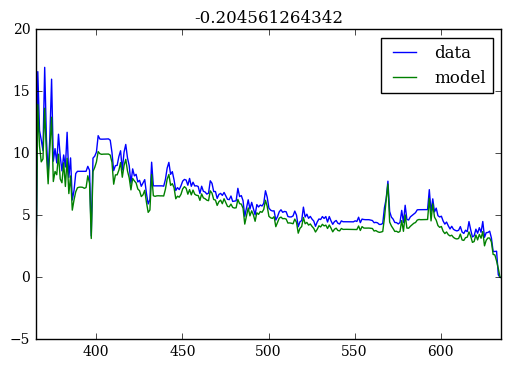

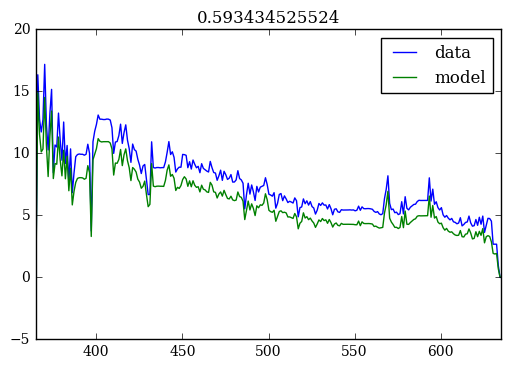

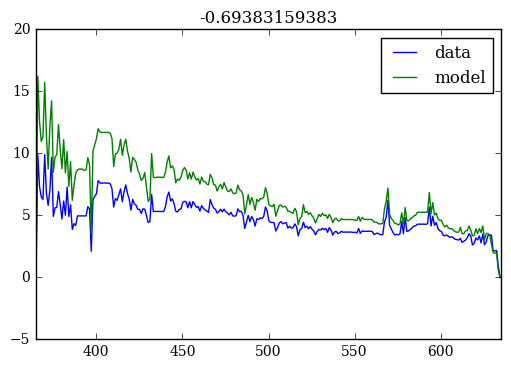

In [34]:
for i in np.random.randint(len(Cont_spectra),size = 10):#len(Cont_spectra)):
    This_spectrum = Cont_spectra[i]
    This_Data = T[i]
    Model_Spectrum = []
    for ii, result in enumerate(Results):
        data = []
        for param in np.array(Data).dtype.names:
            data.append(This_Data[param][ii])
        data = astropy.table.Table(np.array(data),names = np.array(Data).dtype.names)
        Model_Spectrum.append(test_model(result, data))
    
    plt.figure()
    res = This_spectrum - Model_Spectrum
    #plt.plot(Sky.Model['wave_range'], res)
    plt.plot(Sky.Model['wave_range'], This_spectrum, label = 'data')
    plt.plot(Sky.Model['wave_range'], Model_Spectrum, label = 'model')
    plt.title(np.mean(res))
    plt.legend()
    plt.xlim(365,635)